# Spending on Nondurables During the Great Recession

In [1]:
# Initial imports and notebook setup, click arrow to show
%matplotlib inline
import matplotlib.pyplot as plt

## Import some things from cstwMPC

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

from util import log_progress

import numpy as np
from copy import deepcopy

import HARK # Prevents import error from Demos repo
from HARK.utilities import plotFuncs

### There Was a Big Drop in Consumption ... 
Between the second and fourth quarters of 2018, nondurables consumption spending in the U.S. dropped by an unprecedented 6.4 percent.  High frequency data show a drop in retail sales of something like 10 percent between the weekend before the Lehmann collapse and the weekend after Lehmann.  

### ... and Uncertainty Could Induce A Drop In Consumption ...  
Increased "uncertainty" has become a popular explanation of much of what happened in the Great Recession -- including this drop.  Qualitatively, it is well known that a perceived increase in labor income uncertainty should induce more saving (less consumption) for precautionary reasons.

### ... But Is the Story _Quantitatively_ Plausible?
But if explaining a 6.4 percent drop in consumption would require an implausibly large increase in uncertainty, the story that uncertainty explains the consumption drop is implausible.  

### Transitory Shocks, Permanent Shocks, or Unemployment
The $\texttt{ConsIndShockConsumerType}$ model incorporates three kinds of uncertainty: Unemployment spells, during which income is reduced to some small proportion of its normal level; and, for consumers who remain employed, transitory and permanent shocks with standard deviations $\sigma_{\theta}$ and $\sigma_{\psi}$.  

### The Question:
How large an increase in the standard deviation of $\sigma_{\psi}$ would be necessary to induce a 6.4 percent drop in consumption in one quarter?  What about $\sigma_{\theta}$?  How high would the perceived unemployment probability have to be?

The first step is to create the agents we want to solve the model for.

Model set up:
- "Standard" infinite horizon consumption/savings model, with mortality and permanent and temporary shocks to income
- Ex-ante heterogeneity in consumers' discount factors
    
With this basic setup, HARK's IndShockConsumerType is the appropriate subclass of $\texttt{AgentType}$. So we need to prepare the parameters to create instances of that class.


In [2]:
# This cell imports calibrated parameters from the cstwMPC project.
init_infinite = {
    "CRRA":1.0,                    # Coefficient of relative risk aversion 
    "Rfree":1.01/(1.0 - 1.0/160.0), # Survival probability,
    "PermGroFac":[1.000**0.25], # Permanent income growth factor (no perm growth),
    "PermGroFacAgg":1.0,
    "BoroCnstArt":0.0,
    "CubicBool":False,
    "vFuncBool":False,
    "PermShkStd":[(0.01*4/11)**0.5],  # Standard deviation of permanent shocks to income
    "PermShkCount":5,  # Number of points in permanent income shock grid
    "TranShkStd":[(0.01*4)**0.5],  # Standard deviation of transitory shocks to income,
    "TranShkCount":5,  # Number of points in transitory income shock grid
    "UnempPrb":0.07,  # Probability of unemployment while working
    "IncUnemp":0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet":None,
    "IncUnempRet":None,
    "aXtraMin":0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax":20,  # Maximum end-of-period assets in grid
    "aXtraCount":20,  # Number of points in assets grid,
    "aXtraExtra":[None],
    "aXtraNestFac":3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb":[1.0 - 1.0/160.0],  # Survival probability
    "DiscFac":0.97,             # Default intertemporal discount factor, # dummy value, will be overwritten
    "cycles":0,
    "T_cycle":1,
    "T_retire":0,
    'T_sim':1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    'T_age': 400,
    'IndL': 10.0/9.0,  # Labor supply per individual (constant),
    'aNrmInitMean':np.log(0.00001),
    'aNrmInitStd':0.0,
    'pLvlInitMean':0.0,
    'pLvlInitStd':0.0,
    'AgentCount':10000,
}

Now we import the class itself and make a baseline type.  For this exercise, we will introduce ex ante heterogeneity, so the baseline type will be copied several times.

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
BaselineType = IndShockConsumerType(**init_infinite)

Now we can add in ex-ante heterogeneity in consumers' discount factors.

First, let's create a list with seven copies of our baseline type.

In [4]:
num_consumer_types   = 7 # declare the number of types we want
ConsumerTypes = [] # initialize an empty list

for nn in range(num_consumer_types):
    # Now create the types, and append them to the list ConsumerTypes
    NewType = deepcopy(BaselineType)
    NewType.seed = nn # give each consumer type a different RNG seed
    ConsumerTypes.append(NewType)

Now we can give each of the consumer types their own discount factor. (This distribution of parameters was estimated in the paper ["The Distribution of Wealth and the Marginal Propensity to Consume" by Carroll, Slacalek, Tokuoka, and White (2017)](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC).)

In [5]:
from HARK.utilities import approxUniform

# First, decide the discount factors to assign
bottomDiscFac  = 0.9800
topDiscFac     = 0.9934 
DiscFac_list   = approxUniform(N=num_consumer_types,bot=bottomDiscFac,top=topDiscFac)[1]

# Now, assign the discount factors we want
for j in range(num_consumer_types):
    ConsumerTypes[j].DiscFac = DiscFac_list[j]

Our agents now exist and have a concept of the problem they face, but we still need to solve that problem.

Once we have solved each type of consumer's individual problem, we need to know the distribution of wealth (and permanent income) that the population would achieve in the long run.

The cell below does both of those tasks, looping through the consumer types. For each one, it solves that type's infinite horizon model, then simulates 1000 periods to generate an approximation to the long run distribution of wealth.

In [6]:
for ConsumerType in log_progress(ConsumerTypes, every=1):
    ### First solve the problem for this ConsumerType.
    ConsumerType.solve()
    
    ### Now simulate many periods to get to the stationary distribution
    ConsumerType.T_sim = 1000
    ConsumerType.initializeSim()
    ConsumerType.simulate()

With all of that setup taken care of, let's write some functions to run our counterfactual exercise and extract the information we want.

First, let's define a simple function that merely calculates the average consumption level across the entire population in the most recent simulated period.

In [7]:
def calcAvgC(ConsumerTypes):
    """
    This function calculates average consumption in the economy in last simulated period,
    averaging across ConsumerTypes.
    """
    # Make arrays with all types' (normalized) consumption and permanent income level
    cNrm = np.concatenate([ThisType.cNrmNow for ThisType in ConsumerTypes])
    pLvl = np.concatenate([ThisType.pLvlNow for ThisType in ConsumerTypes])
    
    # Calculate and return average consumption level in the economy
    avgC = np.mean(cNrm*pLvl) 
    return avgC

Now let's create a function to run the experiment we want -- change income uncertainty, and see how consumption changes.
To keep the code block below (mostly) clean, we'll describe the procedure below step by step here, with accompanying annotations in the codeblock.

1. Initialize an empty list to hold the changes in consumption that happen after parameters change, and calculate average consumption before the change in uncertainty.
2. Loop through the new income parameter values to assign. For each parameter value:
 1. Assign the parameter value to the agents
 2. Re-solve the agent's model
 3. Make sure the agents have the correct distribution of states.
 4. Simulate one more period-- the first period after the change in risk.
 5. Calculate the population average consumption level
 6. Translate the new average consumption level as percentage change vs the prior level.
3. Return the list of percentage changes

In [8]:
def calcConsChangeAfterUncertaintyChange(OriginalTypes,NewVals,ParamToChange):
    '''
    Calculate the change in aggregate consumption for a list of values that a parameter will take on.
    
    Parameters
    ----------
    OriginalTypes : [IndShockConsumerType]
        List of consumer types, who have already had their "pre-shock" problem solved and simulated.
    NewVals : np.array
        List or array of new values that the parameter of interest will take on.
    ParamToChange : str
        Name of the income distribution parameter that will be changed.
        
    Returns
    -------
    ChangesInConsumption : [float]
        List of changes in aggregate consumption corresponding to the values in NewVals, as a percentage
        of the original aggregate consumption level.
    '''
    ChangesInConsumption = [] # Step 1
    OldAvgC = calcAvgC(OriginalTypes)

    # Step 2 (the loop over counterfactual parameter values)
    for NewVal in log_progress(NewVals, every=1):
        if ParamToChange in ["PermShkStd","TranShkStd"]:
            ThisVal = [NewVal]
        else:
            ThisVal = NewVal

        ConsumerTypesNew = deepcopy(OriginalTypes)          
        for index,ConsumerTypeNew in enumerate(ConsumerTypesNew):
            setattr(ConsumerTypeNew,ParamToChange,ThisVal) # Step 2A   
            ConsumerTypeNew.updateIncomeProcess()
            ConsumerTypeNew.solve() # Step 2B
            
            ConsumerTypeNew.initializeSim() # Step 2C
            ConsumerTypeNew.aNrmNow = OriginalTypes[index].aNrmNow
            ConsumerTypeNew.pLvlNow = OriginalTypes[index].pLvlNow
            
            ConsumerTypeNew.simOnePeriod() # Step 2D

        NewAvgC = calcAvgC(ConsumerTypesNew) # Step 2E
        ChangeInConsumption = 100. * (NewAvgC - OldAvgC) / OldAvgC # Step 2F
        ChangesInConsumption.append(ChangeInConsumption)

    return ChangesInConsumption # Step 3, returning the output

Our counterfactual experiment function takes three inputs-- consumer types, counterfactual values, and the name of the parameter we want to change. For the sake of convenience, let's define small functions to run the experiment for each parameter with just a single input.

In [9]:
def calcConsChangeAfterPermShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"PermShkStd")

def calcConsChangeAfterTranShkChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"TranShkStd")

def calcConsChangeAfterUnempPrbChange(newVals):
    return calcConsChangeAfterUncertaintyChange(ConsumerTypes,newVals,"UnempPrb")

Now we can finally run our experiment.  In the cell below, we generate a plot of the change in aggregate consumption vs the (underlying) standard deviation of permanent income shocks.  Try to edit the code to run other experiments!

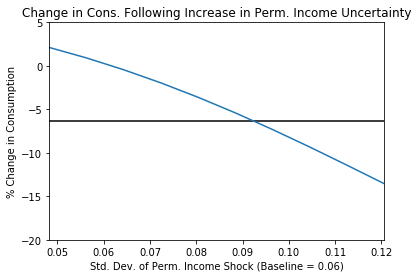

In [10]:
ratio_min = 0.8 # minimum number to multiply income parameter by
TargetChangeInC = -6.32 # Source: FRED
num_points = 10 # number of parameter values to plot in graphs

# First change the variance of the permanent income shock
perm_ratio_max = 2.0 # Put whatever value in you want!  maximum number to multiply std of perm income shock by

perm_min = BaselineType.PermShkStd[0] * ratio_min
perm_max = BaselineType.PermShkStd[0] * perm_ratio_max

plt.ylabel('% Change in Consumption')
plt.xlabel('Std. Dev. of Perm. Income Shock (Baseline = ' + str(round(BaselineType.PermShkStd[0],2)) + ')')
plt.title('Change in Cons. Following Increase in Perm. Income Uncertainty')
plt.ylim(-20.,5.)
plt.hlines(TargetChangeInC,perm_min,perm_max)
plotFuncs([calcConsChangeAfterPermShkChange],perm_min,perm_max,N=num_points)

The figure shows that if people's beliefs about the standard deviation of permanent shocks to their incomes had changed from 0.06 (the default value) about 0.095, the model would predict an immediate drop in consumption spending of about the magnitude seen in 2008.  

The remaining question is whether this is a reasonable or an unreasonable magnitude for a change in uncertainty.  Some perspective on that question is offered by the large literature that attempts to estimate the magnitude of persistent or permanent shocks to household income.  The answer varies substantially across household types, countries, and time periods, but our sense of the literature is that the whole span of the territory between 0.04 and ranging nearly up to 0.20 is well populated (in the sense that substantial populations of people or countries have been estimated to experience shocks of this magnitude).

So, the degree to which income uncertainty would have had to rise in order to explain the drop in consumption in the Great Recession is quite moderate, compared to the variation that is estimated already to exist across people, places, times, and countries.

In [11]:
# Exercises: